# Test
DEM_raster   
flowline_raster

# Compute Cell Attributes:
- smooth dem (wbt)
- compute slope (xrspatial)
- compute curvature (wbt)
- compute hand (wbt)

# Get Cross Sections:
- vectorize_stream()
- preprocess_centerline()
- fix_alphas()
- assign_side()
- get dataframe

# Get Bottom Breakpoint:
- get_breakpoints()
- filter_breakpoints()

# Get Valley Bottom Boundary
- quantize_elevations()
- plot()
- cluster()
- get_contour()
- rasterize()


In [77]:
import os

import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from valleys.utils import setup_wbt
from valleys.catchment import wbt_gaussian_filter, wbt_slope, wbt_fill_depressions, wbt_hand, wbt_profile_curvature, wbt_vectorize_stream
from valleys.cross_section import plot_cross_section_profile, map_cross_sections, preprocess_channel, get_cross_section_points

In [5]:
wbt = setup_wbt(whitebox_dir=os.path.expanduser("~/opt/WBT/"), working_dir=os.path.abspath("../data/wb_outputs/"))

In [38]:
dem_file = os.path.abspath("../toydata/example_valleys/180400060403_22_dem.tif")
stream_file = os.path.abspath("../toydata/example_valleys/180400060403_22_stream.tif")

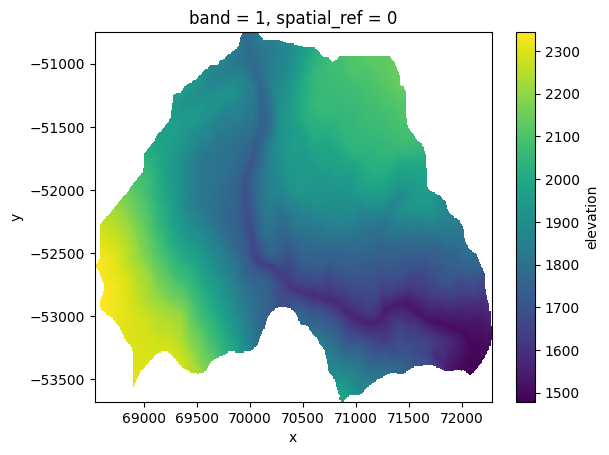

In [39]:
dem = rioxarray.open_rasterio(dem_file).squeeze()
stream = rioxarray.open_rasterio(stream_file).squeeze()

fig, ax = plt.subplots()
dem.plot(ax=ax)

## cell attributes

In [40]:
filled_file = wbt_fill_depressions(wbt, dem_file, "filled.tif")
hand_file = wbt_hand(wbt, filled_file, stream_file, "hand.tif")
smoothed_file = wbt_gaussian_filter(wbt, dem_file, "smoothed.tif", sigma=1)
slope_file = wbt_slope(wbt, smoothed_file, "slope.tif")
curvature_file = wbt_profile_curvature(wbt, smoothed_file, "curvature.tif")

## Cross Sections

In [69]:
# vectorize the stream -> flowline
# preprocess -> centerline
wbt.d8_pointer("filled.tif", "d8_pntr.tif")
stream_shp = wbt_vectorize_stream(wbt, stream_file, os.path.join(wbt.work_dir, "d8_pntr.tif"), "stream.shp")
stream = gpd.read_file(stream_shp, crs=3310)
centerline = stream.simplify(50)

In [204]:
# get points (hand, slope, curvature) -> points_df
# fix alphas, assign sides
from valleys.cross_section import _sample_points

# get points on the centerline
river_points = []
for i in range(0, int(centerline.length), 50):
    point = centerline.interpolate(i)
    river_points.append(point.geometry.iloc[0])

river_points = gpd.GeoSeries(river_points, crs=3310)

# hand, slope, curv
hand = rioxarray.open_rasterio(hand_file).squeeze()
hand = hand.where(hand != -32768, np.nan)
curv = rioxarray.open_rasterio(curvature_file).squeeze()
slope = rioxarray.open_rasterio(slope_file).squeeze()

dfs = []
for i,point in enumerate(river_points):
    res = {}
    alphas, elevations, points = _sample_points(point, centerline.geometry.iloc[0], 100, 10, hand)
    _, slopes, _ = _sample_points(point, centerline.geometry.iloc[0], 100, 10, slope)
    _, curves, _ = _sample_points(point, centerline.geometry.iloc[0], 100, 10, curv)

    res['alpha'] = alphas
    res['elevation'] = elevations
    res['slope'] = slopes
    res['curvature'] = curves
    res['point'] = points
    res['cross_section'] = i
    df = pd.DataFrame(res)
    dfs.append(df)

points_df = pd.concat(dfs)

/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/ipykernel_13879/3872761571.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  for i in range(0, int(centerline.length), 50):


In [211]:
points_df = points_df.loc[points_df['elevation'] != -32768]
points_df.drop_duplicates(inplace=True)
points_df = gpd.GeoDataFrame(points_df, geometry='point', crs=3310)

In [212]:
def fix_alphas(points):
    # if the stream centerline was smoothed, 
    # then the starting point (alpha == 0) may not be where the stream was (elevation = 0)
    # need to find that point, and adjust the alpha values accordingly 

    # could use the streamline and find the nearest point
    temp = points.copy()

    offsets = {}
    for ind in temp['cross_section'].unique():
        df = temp.loc[points['cross_section'] == ind]
        min_ind = df['elevation'].idxmin()
        center = np.where(df['alpha'] == 0)
        
        temp.loc[temp['cross_section'] == ind, 'alpha'] = (df['alpha'] - df['alpha'][min_ind])
    
    return temp

In [213]:
points_df = fix_alphas(points_df)

In [240]:
def _polygonize_raster_bounds(raster):
    exists = raster.where(np.isnan(raster), 1)

    exists.rio.to_raster("temp.tif", dtype="float32")

    with rasterio.open("temp.tif") as src:
        data = src.read(1)

    mask = (data == 1)
    shapes = rasterio.features.shapes(data, mask, transform=src.transform)

    records = []
    for shape, id in shapes:
        coords = shape['coordinates'][0]
        polygon = shapely.Polygon(coords)
        records.append({"geometry": polygon, "id": id})
    df = gpd.GeoDataFrame.from_records(records)

    # cleanup
    os.remove("temp.tif")
    return df['geometry'].iloc[np.argmax(df['geometry'].area)]

def _preprocess_linestring(polygon, linestring):
    # guarantee that the linestring bisects the polygon
    first = Point(linestring.coords[0])
    last = Point(linestring.coords[-1])
    
    nearest_to_first = shapely.ops.nearest_points(polygon, first)[0]
    nearest_to_last = shapely.ops.nearest_points(polygon, last)[0]

    snapped_start_point = shapely.ops.snap(nearest_to_first, polygon, 15)
    snapped_end_point = shapely.ops.snap(nearest_to_last, polygon, 15)
    
    linestring = LineString([snapped_start_point, *linestring.coords])
    linestring = LineString([*linestring.coords, snapped_end_point])
    return linestring

def _get_side_polygons(raster, linestring):
    polygon = _polygonize_raster_bounds(raster)
    linestring = _preprocess_linestring(polygon, linestring)
    splits = shapely.ops.split(polygon, linestring)
    if len(splits.geoms) > 2:
        geometry_sequence = splits.geoms
        areas = [geometry.area for geometry in geometry_sequence]
        indices_of_largest_areas = sorted(range(len(areas)), key=lambda k: areas[k], reverse=True)[:2]
        largest_geometries = [geometry_sequence[i] for i in indices_of_largest_areas]
        return largest_geometries[0], largest_geometries[1]
    side_a = splits.geoms[0]
    side_b = splits.geoms[1]
    return side_a, side_b

def assign_side(df, raster, linestring):
    side_a, side_b = _get_side_polygons(raster, linestring)
    in_a = df.geometry.within(side_a)
    in_b = df.geometry.within(side_b)
    df['side'] = ""
    df.loc[in_a, "side"] = 'A'
    df.loc[in_b, "side"] = 'B'
    return df

In [241]:
import rasterio
import shapely
from shapely.geometry import Point, LineString
side_a, side_b = _get_side_polygons(hand, stream.geometry.iloc[0])
in_a = points_df.geometry.within(side_a)
in_b = points_df.geometry.within(side_b)
points_df['side'] = ""
points_df.loc[in_a, "side"] = 'A'
points_df.loc[in_b, "side"] = 'B'

<Axes: >

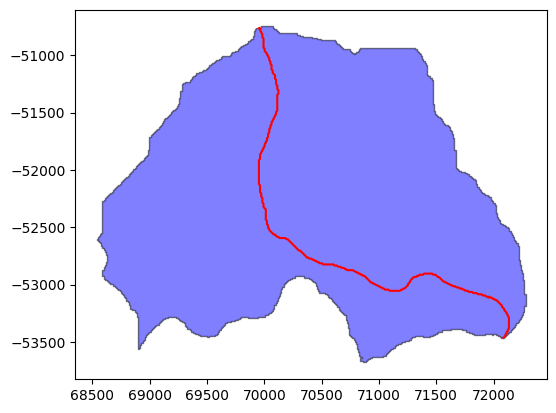

In [242]:
df = gpd.GeoDataFrame(geometry=[polygon, linestring], crs=3310)

fig, ax = plt.subplots()

df[df['geometry'].geom_type == 'Polygon'].plot(color='blue', edgecolor='black', alpha=0.5, ax=ax)
df[df['geometry'].geom_type == 'LineString'].plot(color='red', ax=ax)

In [243]:
in_a.sum() + in_b.sum()

1815

In [244]:
len(points_df)

1848